In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [14]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [15]:
from collections import deque
import random

class Actor:
    def __init__(self, name, input_size, output_size, size_layer):
        with tf.compat.v1.variable_scope(name):
            tf.compat.v1.disable_eager_execution()
            self.X = tf.compat.v1.placeholder(tf.float32, (None, input_size))
            feed_actor = tf.compat.v1.layers.dense(self.X, size_layer, activation = tf.nn.relu)
            self.logits = tf.compat.v1.layers.dense(feed_actor, output_size)

class Critic:
    def __init__(self, name, input_size, output_size, size_layer, learning_rate):
        with tf.compat.v1.variable_scope(name):
            tf.compat.v1.disable_eager_execution()
            self.X = tf.compat.v1.placeholder(tf.float32, (None, input_size))
            self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
            self.REWARD = tf.compat.v1.placeholder(tf.float32, (None, 1))
            feed_critic = tf.compat.v1.layers.dense(self.X, size_layer, activation = tf.nn.relu)
            feed_critic = tf.compat.v1.layers.dense(feed_critic, output_size, activation = tf.nn.relu) + self.Y
            feed_critic = tf.compat.v1.layers.dense(feed_critic, size_layer//2, activation = tf.nn.relu)
            self.logits = tf.compat.v1.layers.dense(feed_critic, 1)
            self.cost = tf.reduce_mean(input_tensor=tf.square(self.REWARD - self.logits))
            self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(self.cost)
            
class Agent:

    LEARNING_RATE = 0.001
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    MEMORY_SIZE = 300
    COPY = 1000
    T_COPY = 0

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.compat.v1.reset_default_graph()
        self.actor = Actor('actor-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.actor_target = Actor('actor-target', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.critic = Critic('critic-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.critic_target = Critic('critic-target', self.state_size, self.OUTPUT_SIZE, 
                                    self.LAYER_SIZE, self.LEARNING_RATE)
        self.grad_critic = tf.gradients(ys=self.critic.logits, xs=self.critic.Y)
        self.actor_critic_grad = tf.compat.v1.placeholder(tf.float32, [None, self.OUTPUT_SIZE])
        weights_actor = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope='actor')
        self.grad_actor = tf.gradients(ys=self.actor.logits, xs=weights_actor, grad_ys=-self.actor_critic_grad)
        grads = zip(self.grad_actor, weights_actor)
        self.optimizer = tf.compat.v1.train.AdamOptimizer(self.LEARNING_RATE).apply_gradients(grads)
        self.sess = tf.compat.v1.InteractiveSession()
        self.sess.run(tf.compat.v1.global_variables_initializer())
    
    def _assign(self, from_name, to_name):
        from_w = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=from_name)
        to_w = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=to_name)
        for i in range(len(from_w)):
            assign_op = to_w[i].assign(from_w[i])
            self.sess.run(assign_op)
            
    def _memorize(self, state, action, reward, new_state, dead):
        self.MEMORIES.append((state, action, reward, new_state, dead))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()
            
    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            prediction = self.sess.run(self.actor.logits, feed_dict={self.actor.X:[state]})[0]
            action = np.argmax(prediction)
        return action
    
    def _construct_memories_and_train(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.sess.run(self.actor.logits, feed_dict={self.actor.X: states})
        Q_target = self.sess.run(self.actor_target.logits, feed_dict={self.actor_target.X: states})
        grads = self.sess.run(self.grad_critic, feed_dict={self.critic.X:states, self.critic.Y:Q})[0]
        self.sess.run(self.optimizer, feed_dict={self.actor.X:states, self.actor_critic_grad:grads})
        
        rewards = np.array([a[2] for a in replay]).reshape((-1, 1))
        rewards_target = self.sess.run(self.critic_target.logits, 
                                       feed_dict={self.critic_target.X:new_states,self.critic_target.Y:Q_target})
        for i in range(len(replay)):
            if not replay[0][-1]:
                rewards[i] += self.GAMMA * rewards_target[i]
        cost, _ = self.sess.run([self.critic.cost, self.critic.optimizer], 
                                feed_dict={self.critic.X:states, self.critic.Y:Q, self.critic.REWARD:rewards})
        return cost
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign('actor-original', 'actor-target')
                    self._assign('critic-original', 'critic-target')
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                state = next_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories_and_train(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [16]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

C:\Users\joshu\AppData\Local\Temp\ipykernel_4548\817982328.py:9: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_actor = tf.compat.v1.layers.dense(self.X, size_layer, activation = tf.nn.relu)
C:\Users\joshu\AppData\Local\Temp\ipykernel_4548\817982328.py:10: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(feed_actor, output_size)
C:\Users\joshu\AppData\Local\Temp\ipykernel_4548\817982328.py:19: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_critic = tf.compat.v1.layers.dense(self.X, size_layer, activation = tf.nn.relu)
C:\Users\joshu\AppData\Local\Temp\ipykernel_4548\817982328.py:20: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.

epoch: 10, total rewards: 1660.170106.3, cost: 0.121613, total money: 10691.720094
epoch: 20, total rewards: 1458.459901.3, cost: 43.049679, total money: 7515.869874
epoch: 30, total rewards: 1164.574646.3, cost: 20293.482422, total money: 9175.374633
epoch: 40, total rewards: 125.149776.3, cost: 620435520.000000, total money: 7141.139765
epoch: 50, total rewards: 448.609860.3, cost: 3284312.000000, total money: 10448.609860
epoch: 60, total rewards: 850.270206.3, cost: 64312848.000000, total money: 3929.690189
epoch: 70, total rewards: 414.544919.3, cost: 663118656.000000, total money: 2503.114926
epoch: 80, total rewards: 753.690069.3, cost: 18688442368.000000, total money: 5862.370061
epoch: 90, total rewards: 2239.344850.3, cost: 33791592448.000000, total money: 7396.674867
epoch: 100, total rewards: 727.959781.3, cost: 305894129664.000000, total money: 3815.179751
epoch: 110, total rewards: 511.310299.3, cost: 1557805268992.000000, total money: 9494.200314
epoch: 120, total reward

In [17]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 4: buy 1 unit at price 790.510010, total balance 9209.489990
day 5, sell 1 unit at price 785.309998, investment -0.657805 %, total balance 9994.799988,
day 8: buy 1 unit at price 736.080017, total balance 9258.719971
day 11: buy 1 unit at price 771.229980, total balance 8487.489991
day 15: buy 1 unit at price 760.989990, total balance 7726.500001
day 18, sell 1 unit at price 770.840027, investment 4.722314 %, total balance 8497.340028,
day 19: buy 1 unit at price 758.039978, total balance 7739.300050
day 21: buy 1 unit at price 750.500000, total balance 6988.800050
day 22: buy 1 unit at price 762.520020, total balance 6226.280030
day 23: buy 1 unit at price 759.109985, total balance 5467.170045
day 25, sell 1 unit at price 776.419983, investment 0.672951 %, total balance 6243.590028,
day 26, sell 1 unit at price 789.289978, investment 3.718838 %, total balance 7032.880006,
day 27: buy 1 unit at price 789.270020, total balance 6243.609986
day 31: buy 1 unit at price 790.799988, tota

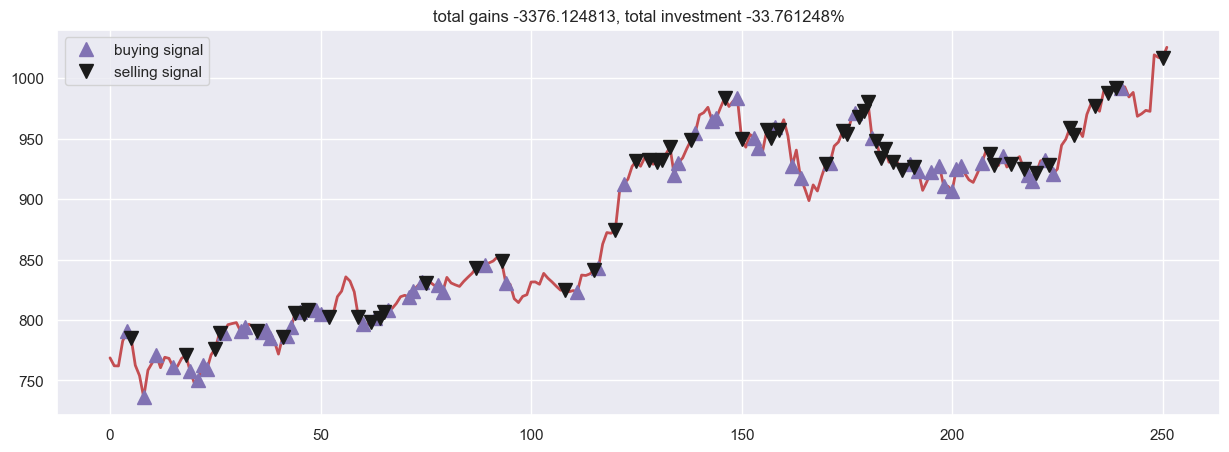

In [18]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()